Parsed with column specification:
cols(
  .default = col_double(),
  `#OTU ID` = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  Sample_ID = col_character(),
  Treatment = col_character()
)
Parsed with column specification:
cols(
  `#OTU ID` = col_character(),
  Taxonomy = col_character()
)
Warning message:
“Expected 7 pieces. Additional pieces discarded in 5010 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”

[1] "overview_feature_foldchange common_feature  completed Successfully.!!!"


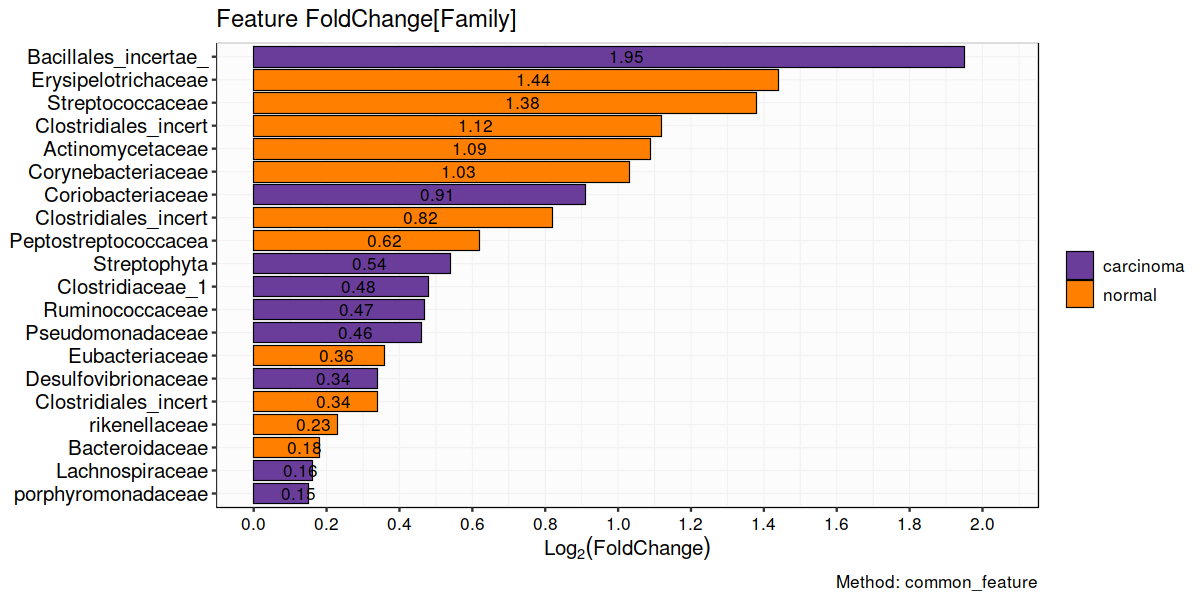

In [2]:
#####################
# Library Loading
#####################
suppressPackageStartupMessages(library(tidyverse))
library(ggplot2)
library(tools)
library(ggsci)
library(scales)
library(ComplexHeatmap)
library(cowplot)
library(gplots)
library(RColorBrewer)
library(gridExtra)
library(ggrepel)
library(hrbrthemes)
######################
# SETTING
######################
args = commandArgs(trailingOnly=TRUE)
options(scipen=10000000)
PLOTLY_Pallett = c('#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf')
JCO_PALLETT = pal_jco("default")(10)
FEATURE_PALLETT = PLOTLY_Pallett
SAMPLE_PALLETT = c("#6A3D9A", "#FF7F00")
OFFLINE_MODE=FALSE

#Lineage_List = c("Phylum", "Family", "Genus", "Species")
Lineage_List = c("Family")
#OTU count limit
OTU_COUNT_LIMIT = 20


if(OFFLINE_MODE==FALSE){
    options(repr.plot.width=10, repr.plot.height=5)
}
######################
# INPUT/OUTPUT
#####################
if(OFFLINE_MODE==FALSE){
    abundance_file_Path = "/data/shamsaddinisha/Projects/MBAC/MetaBiomMiner/Zackular/Zackular_Cancer_Normal/aggregate_abundance/Zackular_Cancer_Normal.OTU_abundance.txt"
    metadata_file_Path = "/data/shamsaddinisha/Projects/MBAC/MetaBiomMiner/Zackular/Zackular_Cancer_Normal/aggregate_metadata/Zackular_Cancer_Normal.metadata.txt"
    taxonomy_file_Path = "/data/shamsaddinisha/Projects/MBAC/MetaBiomMiner/Zackular/Zackular_Cancer_Normal/aggregate_taxonomy/Zackular_Cancer_Normal.OTU_taxonomy.txt"
    the_Selection_Mode = "common_feature"
    plot_output = "./Zackular_Cancer_Normal.overview.txt"
}else{
    abundance_file_Path = args[1]
    metadata_file_Path = args[2]
    taxonomy_file_Path = args[3]
    the_Selection_Mode = args[4]
    plot_output = args[5]
}
#####################
# READ I/O
#####################
abundance_DF = read_tsv(abundance_file_Path)
#head(abundance_DF)
#dim(abundance_DF)
metadata_DF = read_tsv(metadata_file_Path)
#head(metadata_DF)
#dim(metadata_DF)
taxonomy_DF = read_tsv(taxonomy_file_Path)
#head(taxonomy_DF)
#dim(taxonomy_DF)
####################
# Touch-Base
####################
colnames(abundance_DF)[colnames(abundance_DF)=="#OTU ID"] <- "OTU_ID"
colnames(taxonomy_DF)[colnames(taxonomy_DF)=="#OTU ID"] <- "OTU_ID"

#
design_List = sort(unique(metadata_DF$Treatment))
#design_List = append(design_List, "common")
design_list_Length = length(design_List)

####################
#Sample ORDER/COLOR
####################
Sample_Size = length(design_List)
Sample_Order_List = design_List
Sample_Label_Dict = Sample_Order_List
names(Sample_Label_Dict) = Sample_Order_List
Sample_Order_Factor = factor(Sample_Order_List, levels=Sample_Order_List)
Sample_Color_List = SAMPLE_PALLETT[1:Sample_Size]
Sample_Color_Dict = Sample_Color_List
names(Sample_Color_Dict) = Sample_Order_List
####################
# Data Wrangling
####################


#1-gather abundance
gather_abundance_DF = abundance_DF %>% 
    gather(
    	Sample_ID, Abundance, -OTU_ID
    	)
#head(gather_abundance_DF)
#dim(gather_abundance_DF)

#2-Abundance + metadata
metadata_gather_abundance_DF = metadata_DF %>%
    inner_join(
    	gather_abundance_DF, by = c("Sample_ID" = "Sample_ID")
    	)
#head(metadata_gather_abundance_DF)
#dim(metadata_gather_abundance_DF)


#taxonomy + processed_correlation_DF
taxonomy_metadata_gather_abundance_DF= metadata_gather_abundance_DF %>%
        inner_join(
            taxonomy_DF, by = c("OTU_ID" = "OTU_ID")
            ) %>%
        separate(
            Taxonomy, into=c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"), sep = ";"
            )
#head(taxonomy_metadata_gather_abundance_DF)
#dim(taxonomy_metadata_gather_abundance_DF)



#6- For-Loop
Lineage_Length = length(Lineage_List)
for(each_lineage_index in 1:Lineage_Length){
    ##

    
    #1- select lineage
    lineage_DF = taxonomy_metadata_gather_abundance_DF %>%
        #renaming each lineage to Lineage
        rename(Lineage = Lineage_List[[each_lineage_index]]) %>%
        # select required column
        select(c(Treatment, Sample_ID, Lineage, Abundance))
    #print(head(lineage_DF))
    #print(dim(lineage_DF))

    

    ################################
    #SELECT TOP FEATURE
    ################################

    #
    total_otu_count = length(unique(lineage_DF$Lineage))
    if(total_otu_count <= OTU_COUNT_LIMIT){
        #
        OTU_Limit = total_otu_count 
    }else{
        #
        OTU_Limit = OTU_COUNT_LIMIT
    }

    #2- LOG2FC_DF
    LOG2FC_DF = lineage_DF %>%
        select(c(Lineage, Treatment, Abundance)) %>%
        group_by(Lineage, Treatment) %>%
        summarize(Total=sum(Abundance)) %>%
        spread(Treatment, Total) %>%
        summarise(LOG2FC=round(log2(get(design_List[[1]]) + 1) - log2(get(design_List[[2]]) + 1), 2)) %>%
        mutate(abs_LOG2FC=abs(LOG2FC), Direction=ifelse(LOG2FC >= 0, design_List[[1]], ifelse(LOG2FC< 0 , design_List[[2]], "common")))
    #print(LOG2FC_DF)
    #print(dim(LOG2FC_DF))

    #3- selected feature DF
    if(the_Selection_Mode == "common_feature"){
        selected_feature_DF = LOG2FC_DF %>%
            arrange(abs_LOG2FC) %>%
            head(OTU_Limit)
    }
    else if(the_Selection_Mode == "distinct_feature"){
        selected_feature_DF = LOG2FC_DF %>%
            arrange(desc(abs_LOG2FC)) %>%
            head(OTU_Limit)

    }

    #print(selected_feature_DF)
    #print(dim(selected_feature_DF))

    
    ################################
    #BUILD FEATURE FOLDCHANGE DF
    ################################

    feature_foldchange_DF = LOG2FC_DF
        
                                
    #print(feature_foldchange_DF)
    #print(dim(feature_foldchange_DF))
    
    selected_feature_foldchange_DF = feature_foldchange_DF %>%
        filter(Lineage %in% selected_feature_DF$Lineage) %>%
        arrange(desc(abs_LOG2FC))
    #print(selected_feature_foldchange_DF)
    #print(dim(selected_feature_foldchange_DF))

    ####################
    #FEATURE ORDER/COLOR
    ####################
    Feature_Order_List = unique(selected_feature_foldchange_DF$Lineage)
    Feature_List_Size = length(Feature_Order_List)
    Feature_Label_Dict = Feature_Order_List
    names(Feature_Label_Dict) = Feature_Order_List
    Feature_Order_Factor = factor(Feature_Order_List, levels=Feature_Order_List)
    if(Feature_List_Size > 10){
        Feature_Color_List = colorRampPalette(FEATURE_PALLETT)(Feature_List_Size)
    }else{
        Feature_Color_List = FEATURE_PALLETT[1:Feature_List_Size]
    }
    Feature_Color_Dict = Feature_Color_List
    names(Feature_Color_Dict) = Feature_Order_List

    

    #####################################
    #GGPLOT FEATURE FOLD CHANGE PLOT
    #####################################
    
    top_logFC = selected_feature_foldchange_DF %>% arrange(desc(abs_LOG2FC)) %>% head(1)
    max_x_axis = top_logFC$abs_LOG2FC + 0.1
    min_x_axis = 0.0
                             
    overview_feature_foldchange_ggplot_Object = ggplot(data= selected_feature_foldchange_DF,
        aes(x=reorder(Lineage, abs_LOG2FC), y=abs_LOG2FC, fill=Direction)) +
        geom_bar(stat = "identity", position="identity", color="black", size = 0.25) +
        geom_text(aes(label = abs_LOG2FC), position = position_stack(vjust = 0.5), size=3.5, hjust = 0, color="black") +
        labs(title = paste("Feature FoldChange[",  Lineage_List[[each_lineage_index]], "]", sep=""), subtitle = NULL, caption = paste("Method: ", the_Selection_Mode, sep=""), tag = NULL, x=NULL, y=expression(Log[2]("FoldChange"))) +
        scale_fill_manual(breaks = Sample_Order_List, labels=Sample_Label_Dict, limits=Sample_Order_List, values=Sample_Color_Dict, guide = guide_legend(reverse = FALSE),name = NULL ) +
        scale_y_continuous(limits=c(min_x_axis, max_x_axis), breaks = scales::pretty_breaks(n = 10)) +
        scale_x_discrete(labels = function(x) substr(x, start = 1, stop = 20)) +
        theme_grey() +
        theme(
            text=element_text(family="sans-serif"),
            plot.title = element_text(size=14, color = "black", face = "plain", hjust = 0),
            plot.subtitle = element_text(size=12, color = "black", face = "plain", hjust = 0 ),
            plot.caption = element_text(size=10, color = "black", face = "plain"),
            #X-AXIS
            axis.title.x = element_text(size=12, color = "black", face = "plain"),
            axis.text.x = element_text(size=10, color = "black", face = "plain", angle=0, vjust=0.5),
            #Y-AXIS
            axis.title.y = element_text(size=12, color = "black", face = "plain"),
            axis.text.y = element_text(size=12, color = "black", face = "plain"),
            #Panel
            panel.grid.major = element_line(color = "grey95", size = 0.25), 
            panel.grid.minor = element_line(color = "grey95", size = 0.25),
            panel.background = element_rect(color = "black", size = 0.25, fill = "grey99"),
            panel.border = element_rect(color = "black", size = 0.25, fill = NA),
            #Strip
            strip.text = element_text(size=14, face="plain", color = "black"),
            strip.text.x = element_text(size=12, face="plain", color = "black"),
            strip.text.y = element_text(size=10, face="plain", color = "black"),
            strip.background = element_rect(color = "black", size = 0.25, fill = "grey95"),
            #LEGEND
            #legend.position="none",
            legend.title = element_blank(),
            legend.key=element_blank(),
            legend.text = element_text(size=10, face="plain", color = "black", angle=0, vjust=0.5),
            legend.background = element_blank(),

        ) + 
        coord_flip()

    
    ######################
    #EXPORTING
    ######################
    if(OFFLINE_MODE==TRUE){
        file_extension = file_ext(plot_output)
        #
        plot_PDF = gsub(file_extension, paste(the_Selection_Mode, ".feature_foldchange.", Lineage_List[[each_lineage_index]], ".plot.pdf", sep=""), plot_output)
        plot_PNG = gsub(".pdf", ".png", plot_PDF)
        plot_JPG = gsub(".pdf", ".jpg", plot_PDF)
        plot_SVG = gsub(".pdf", ".svg", plot_PDF)
        plot_TXT = gsub(".pdf", ".txt", plot_PDF)
        #
        ggsave(file=plot_PDF, device=cairo_pdf, plot=overview_feature_foldchange_ggplot_Object, width=10, height =5, units = "in", limitsize = FALSE, dpi=1200)
        ggsave(file=plot_PNG, device="png", plot=overview_feature_foldchange_ggplot_Object, width=10, height =5, units = "in", limitsize = FALSE, dpi=300)
        ggsave(file=plot_JPG, device="jpg", plot=overview_feature_foldchange_ggplot_Object, width=10, height =5, units = "in", limitsize = FALSE, dpi=300)
        ggsave(file=plot_SVG, device="svg", plot=overview_feature_foldchange_ggplot_Object, width=10, height =5, units = "in", limitsize = FALSE, dpi=72)
        write_tsv(path=plot_TXT, x=feature_foldchange_DF)
    }
    

}
if(OFFLINE_MODE==FALSE){
        overview_feature_foldchange_ggplot_Object
}

print(paste("overview_feature_foldchange", the_Selection_Mode, " completed Successfully.!!!"))